In [1]:
import warnings
import itertools
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from pandas import read_csv



### Load full dataset 

In [2]:


series = read_csv('dataset.csv', header=0, index_col=0, parse_dates=True, squeeze=True)



### Select one user 

In [3]:
data= series.loc['Z8RsBpxhnkebK5fvahVCmfV7icO2']

In [4]:
data.head()

,time,valueHR,valuesteps,WkHR,WkCal,WkSteps,sec,sugarValue,cal,carbs,fat,fiber,protein,sodium
uid,,,,,,,,,,,,,,
Z8RsBpxhnkebK5fvahVCmfV7icO2,2019-12-16 00:15:00,72.0,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Z8RsBpxhnkebK5fvahVCmfV7icO2,2019-12-16 00:30:00,70.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Z8RsBpxhnkebK5fvahVCmfV7icO2,2019-12-16 00:45:00,71.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Z8RsBpxhnkebK5fvahVCmfV7icO2,2019-12-16 01:00:00,71.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Z8RsBpxhnkebK5fvahVCmfV7icO2,2019-12-16 01:15:00,68.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
data['time']=pd.to_datetime(data['time'], format='%Y-%m-%d %H:%M:%S')
data.set_index(['time'], inplace=True)

C:\Users\anto-\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [6]:
dataSugar = data[['sugarValue']]


dataSugar = dataSugar.drop(dataSugar[dataSugar.sugarValue > 300].index, inplace=False)

dataSugar= dataSugar.dropna()

In [7]:
dataSugar

,sugarValue
time,
2020-01-09 12:00:00,90.82098
2020-01-09 12:15:00,90.61686
2020-01-09 12:30:00,86.22828
2020-01-09 12:45:00,82.04382
2020-01-09 13:00:00,79.90056
...,...
2020-01-23 21:00:00,102.35376
2020-01-23 21:15:00,102.76200
2020-01-23 21:30:00,108.47736


### Group data for day and plot current data

In [8]:
dataSugar =dataSugar.groupby(dataSugar.index.date).mean()

This graph shot the mean of sugar value (by CGM) for days from 2020-01-09 to 2020-01-23

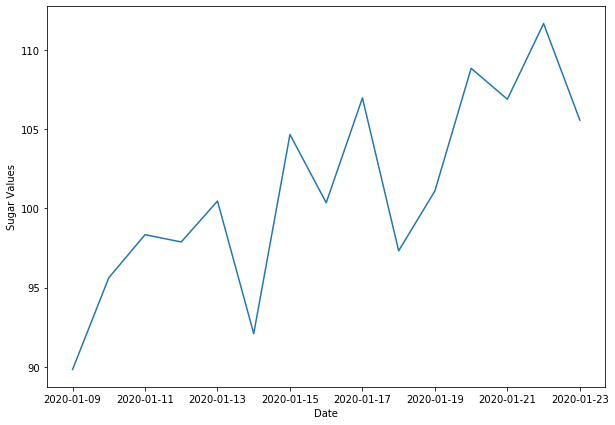

In [10]:
fig = plt.figure(figsize=(10,7))

plt.plot(dataSugar.dropna())
plt.ylabel('Sugar Values')
plt.xlabel('Date')
plt.show()


### Apply ARIMA MODEL

Evaluate the model with different parameters 

In [32]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 365) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 365)
SARIMAX: (0, 0, 1) x (0, 1, 0, 365)
SARIMAX: (0, 1, 0) x (0, 1, 1, 365)
SARIMAX: (0, 1, 0) x (1, 0, 0, 365)


In [43]:
warnings.filterwarnings("ignore") # specify to ignore warning messages

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(dataSugar,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('ARIMA{}x{}365 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 365)365 - AIC:171.2617189599934
ARIMA(0, 0, 0)x(0, 0, 1, 365)365 - AIC:4.0
ARIMA(0, 0, 0)x(0, 1, 0, 365)365 - AIC:2.0
ARIMA(0, 0, 0)x(0, 1, 1, 365)365 - AIC:4.0
ARIMA(0, 0, 0)x(1, 0, 0, 365)365 - AIC:4.0
ARIMA(0, 0, 0)x(1, 0, 1, 365)365 - AIC:6.0
ARIMA(0, 0, 0)x(1, 1, 0, 365)365 - AIC:4.0
ARIMA(0, 0, 0)x(1, 1, 1, 365)365 - AIC:6.0
ARIMA(0, 0, 1)x(0, 0, 0, 365)365 - AIC:147.41585435409448
ARIMA(0, 0, 1)x(0, 0, 1, 365)365 - AIC:6.0
ARIMA(0, 0, 1)x(0, 1, 0, 365)365 - AIC:4.0
ARIMA(0, 0, 1)x(0, 1, 1, 365)365 - AIC:6.0
ARIMA(0, 0, 1)x(1, 0, 0, 365)365 - AIC:6.0
ARIMA(0, 0, 1)x(1, 0, 1, 365)365 - AIC:8.0
ARIMA(0, 0, 1)x(1, 1, 0, 365)365 - AIC:6.0
ARIMA(0, 0, 1)x(1, 1, 1, 365)365 - AIC:8.0
ARIMA(0, 1, 0)x(0, 0, 0, 365)365 - AIC:87.22314400973863
ARIMA(0, 1, 0)x(0, 0, 1, 365)365 - AIC:4.0
ARIMA(0, 1, 0)x(0, 1, 0, 365)365 - AIC:2.0
ARIMA(0, 1, 0)x(0, 1, 1, 365)365 - AIC:4.0
ARIMA(0, 1, 0)x(1, 0, 0, 365)365 - AIC:4.0
ARIMA(0, 1, 0)x(1, 0, 1, 365)365 - AIC:6.0
ARIMA(0, 1,

### Compute a model with chosen parameter 

In [176]:
mod = sm.tsa.statespace.SARIMAX(dataSugar,
                                order=(1, 1, 1),
                                seasonal_order=(0, 0, 0, 365),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6437      0.448     -1.438      0.150      -1.521       0.234
ma.L1         -0.0508      0.740     -0.069      0.945      -1.501       1.400
sigma2        25.0681     25.531      0.982      0.326     -24.971      75.108


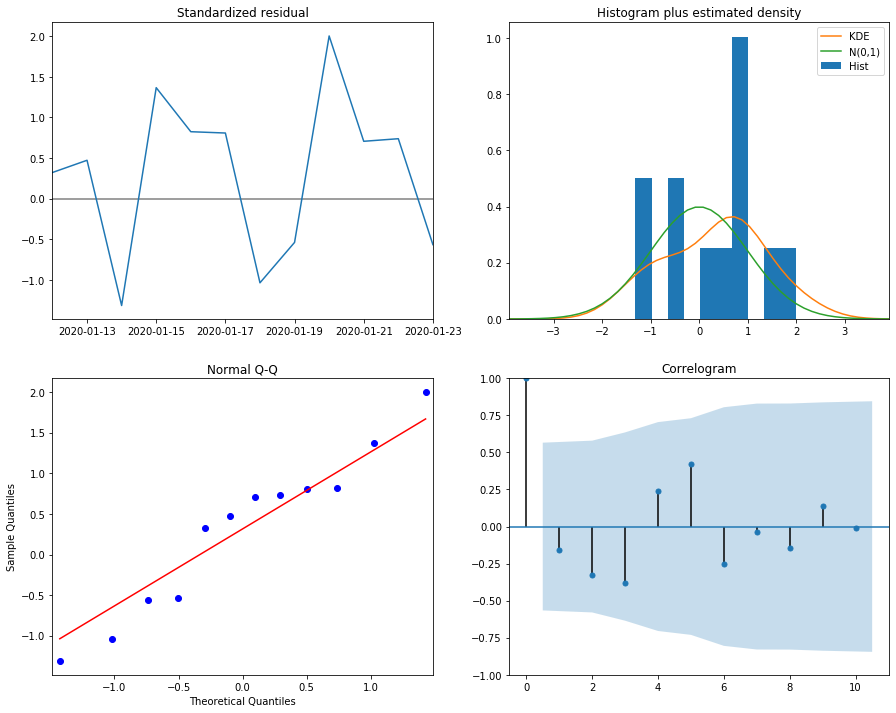

In [177]:
results.plot_diagnostics(figsize=(15, 12))
plt.show()

We have obtained a model for our time series that can now be used to produce forecasts. We start by comparing predicted values to real values of the time series, which will help us understand the accuracy of our forecasts. The get_prediction() and conf_int() attributes allow us to obtain the values and associated confidence intervals for forecasts of the time series.

The code above requires the forecasts to start at 2020-01-21.

The dynamic=False argument ensures that we produce one-step ahead forecasts, meaning that forecasts at each point are generated using the full history up to that point.

We can plot the real and forecasted values of the CGM time series to assess how well we did.

In [180]:
pred = results.get_prediction(start=pd.to_datetime('2020-01-18'), dynamic=False)
pred_ci = pred.conf_int()

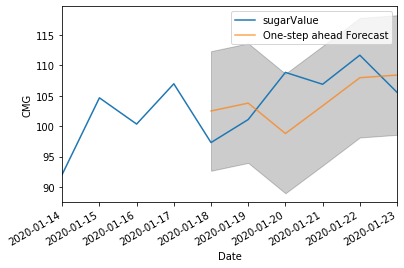

In [181]:
ax = dataSugar[pd.to_datetime('2020-01-14'):].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7)

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('CMG')
plt.legend()

plt.show()

#### Compute the mean square error

In [182]:
y_forecasted = pred.predicted_mean
y_truth = dataSugar[pd.to_datetime('2020-01-18'):]

df = pd.DataFrame(y_forecasted, columns = ['sugarValue'])



mse = ((df - y_truth) ** 2).mean()


print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is sugarValue    28.16
dtype: float64


### Evaluate a dynamic Forecast 

However, a better representation of our true predictive power can be obtained using dynamic forecasts. In this case, we only use information from the time series up to a certain point, and after that, forecasts are generated using values from previous forecasted time points.

For use this prediction is enought add "dynamic=True"

In [183]:
pred_dynamic = results.get_prediction(start=pd.to_datetime('2020-01-18'), dynamic=True, full_results=True)
pred_dynamic_ci = pred_dynamic.conf_int()

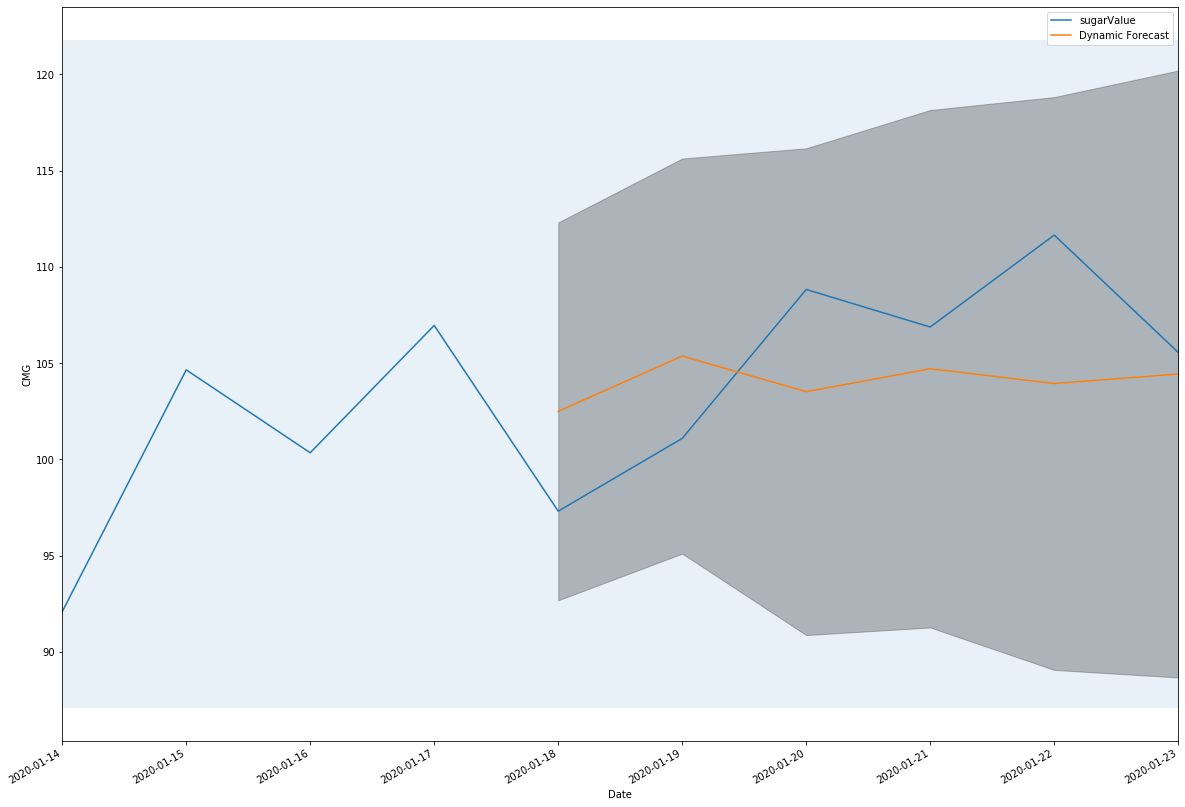

In [184]:
ax = dataSugar[pd.to_datetime('2020-01-14'):].plot(label='observed', figsize=(20, 15))
pred_dynamic.predicted_mean.plot(label='Dynamic Forecast', ax=ax)

ax.fill_between(pred_dynamic_ci.index,
                pred_dynamic_ci.iloc[:, 0],
                pred_dynamic_ci.iloc[:, 1], color='k', alpha=.25)

ax.fill_betweenx(ax.get_ylim(),'2020-01-14', dataSugar.index[-1],
                 alpha=.1, zorder=-1)

ax.set_xlabel('Date')
ax.set_ylabel('CMG')

plt.legend()
plt.show()

In [185]:
# Extract the predicted and true values of our time series
y_forecasted = pred_dynamic.predicted_mean
y_truth = dataSugar[pd.to_datetime('2020-01-18'):]

y_forecasted = pd.DataFrame(y_forecasted, columns = ['sugarValue'])

# Compute the mean square error
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is sugarValue    23.12
dtype: float64



The predicted values obtained from the dynamic forecasts is slightly higher than the one-step ahead, which is to be expected given that we are relying on less historical data from the time series.

### Forecast in the next 7 days after data.

Get forecast 7 steps ahead in future, and use pred_uc_conf_ int() that rappresent a confidence interval. 

In [186]:

pred_uc = results.get_forecast(steps=7)


pred_ci = pred_uc.conf_int()

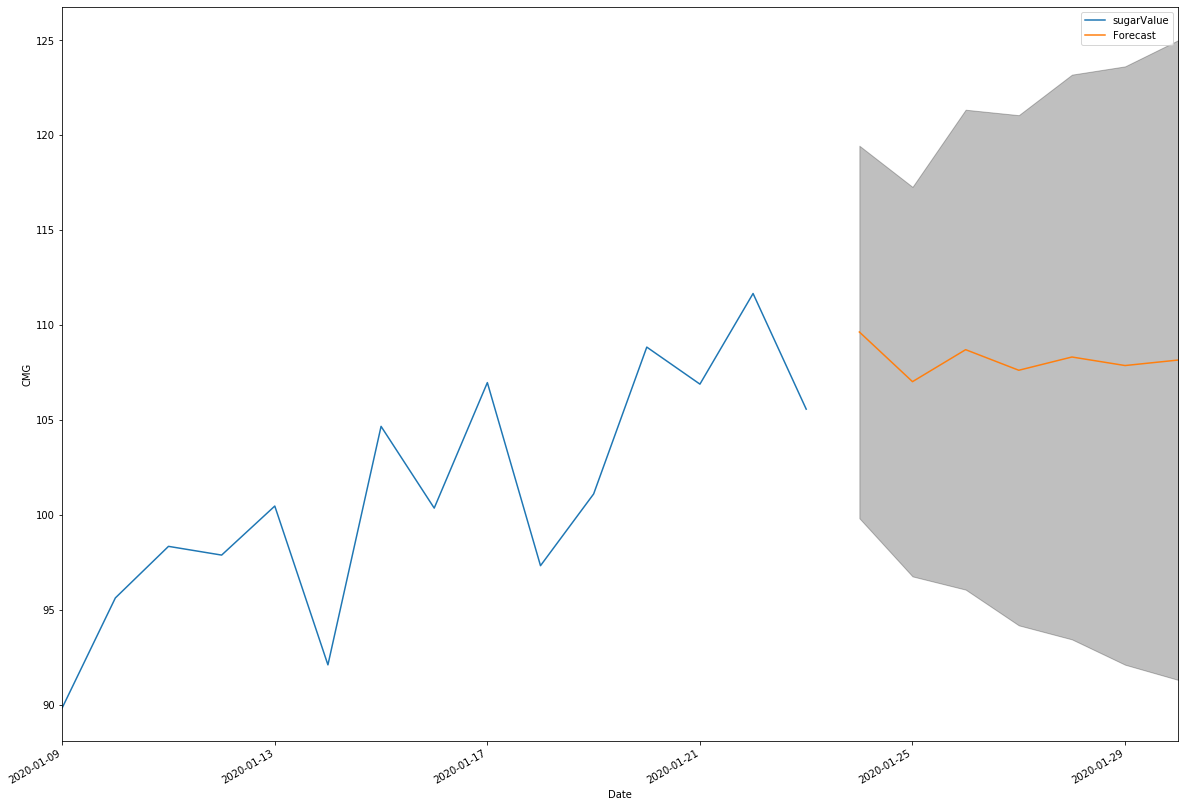

In [190]:
ax = dataSugar.plot(label='observed', figsize=(20, 15))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('CMG')

plt.legend()
plt.show()

In [188]:
pred_uc.predicted_mean

2020-01-24    109.626705
2020-01-25    107.009534
2020-01-26    108.694314
2020-01-27    107.609752
2020-01-28    108.307929
2020-01-29    107.858484
2020-01-30    108.147811
Freq: D, dtype: float64